# Task 2 - Regression (World Happiness Dataset)

## Substantive Issue

*Topic: Understanding the predictors of happiness through machine learning regression.*

Happiness and well-being are increasingly acknowledged as essential indicators of a country's development. Understanding the factors that contribute to overall happiness levels can become insightful information for governments and organisations in shaping public policies that prioritise the countries' social development. The "World Happiness Dataset" explores the factors contributing to happiness and well-being worldwide. The target variable, "Life Ladder" represents overall happiness which is influenced by factors such as "GDP", "Social Support" and "Life Expectancy".

## Research Questions

The research questions (RQs) identified for this study are as follows:

**RQ 1**: Can happiness scores be accurately predicted using GDP, social support, health and freedom metrics?

**RQ 2**: How do different regression models compare in predicting happiness scores?

**RQ 3**: Which feature(s) has (have) the strongest influencee on happiness scores?

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Load Dataset

In [2]:
# Load the World Happiness 2024 Dataset
data = pd.read_excel('/Users/joline/Desktop/ml coursework datasets/World Happiness/Data 1.xlsx')

In [3]:
# Show the first 5 rows of the dataset
data.head()

Country name  year  Life Ladder  Log GDP per capita  Social support  \
0  Afghanistan  2008     3.723590            7.350416        0.450662   
1  Afghanistan  2009     4.401778            7.508646        0.552308   
2  Afghanistan  2010     4.758381            7.613900        0.539075   
3  Afghanistan  2011     3.831719            7.581259        0.521104   
4  Afghanistan  2012     3.782938            7.660506        0.520637   

   Healthy life expectancy at birth  Freedom to make life choices  Generosity  \
0                         50.500000                      0.718114    0.164055   
1                         50.799999                      0.678896    0.187297   
2                         51.099998                      0.600127    0.117861   
3                         51.400002                      0.495901    0.160098   
4                         51.700001                      0.530935    0.234157   

   Perceptions of corruption  Positive affect  Negative affect  
0                   0.881686         0.414297         0.258195  
1                   0.850035         0.481421         0.237092  
2                   0.706766         0.516907         0.275324  
3                   0.731109         0.479835         0.267175  
4                   0.775620         0.613513         0.267919

#### The dataset contains the following columns:

- Country Name

- Year

- Life Ladder

Also known as "Happiness Score". The national average response to the question of life evaluations, represented as a scale from 0 (worst possible life) to 10 (best possible life).

- Log GDP per capita

Measured in purchasing power parity (PPP) at constant 2017 international dollar prices. Values are extended to 2023 using country-specific GDP growth projections.

- Social support

The national average of binary responses (0 or 1) to the question: "If you were in trouble, do you have relatives or friends you can count on to help you whenever you need them?"

- Healthy life expectancy at birth

The average number of healthy years expected at birth, derived from World Health Organisation data.

- Freedom to make life choices

The national average of responses to the question: "Are you satisfied or dissatisfied with your freedom ro choose what you do with your life?"

- Generosity

The residual of regressing the national average response to the question: "Have you denoted money to a charity in the past month?" on GDP per capita.

- Perceptions of corruption

The national average of responses to two questions: "Is corruption widespread throughout the government?" and "Is corruption widespread within businesses?"

- Positive affect

The average of responses to three questions: "Did you smile or laugh a lot yesterday?", "Did you experience enjoyment yesterday?" and "Did you learn or do something interesting yesterday?"

- Negative affect

The average of responses to three questions: "Did you experience worry yesterday?", "Did you experience sadness yesterday?" and "Did you experience anger yesterday?"

## Data Cleaning

In [4]:
# Check for duplicates in the dataset
duplicated_rows_mask = data.duplicated(keep=False)

# Print and display duplicated rows if any
if duplicated_rows_mask.any():
    print("\nDuplicated Rows:")
    print(data[duplicated_rows_mask])  # Use the Boolean mask to filter duplicate rows
else:
    print("No duplicated rows found.")

No duplicated rows found.


In [5]:
# Check for missing values in the dataset
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100

# Create a dataframe for missing data
missing_summary = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
}).sort_values(by = 'Missing Percentage')

# Show missing data summary
missing_summary

Missing Count  Missing Percentage
Country name                                  0            0.000000
year                                          0            0.000000
Life Ladder                                   0            0.000000
Social support                               13            0.550148
Negative affect                              16            0.677105
Positive affect                              24            1.015658
Log GDP per capita                           28            1.184934
Freedom to make life choices                 36            1.523487
Healthy life expectancy at birth             63            2.666102
Generosity                                   81            3.427846
Perceptions of corruption                   125            5.289886

In [6]:
# Handle missing values
numerical_cols = data.select_dtypes(include=['float64']).columns
imputer = SimpleImputer(strategy='median')
data[numerical_cols] = imputer.fit_transform(data[numerical_cols])

In [7]:
# Separate 'Perceptions of corruption'
corruption_col = 'Perceptions of corruption'
missing_less_than_5 = [
    col for col in numerical_cols if col != corruption_col and (data[col].isnull().mean() < 0.05)
]

Median imputation is suitable for features with minimal missing data (<5%) as it is robust to outliers.

In [8]:
# Median Imputation for columns with <5% missing values
median_imputer = SimpleImputer(strategy='median')
data[missing_less_than_5] = median_imputer.fit_transform(data[missing_less_than_5])

KNN imputation is used for 'Perceptions of corruption' to leverage relationships between features and provide more accurate estimates for columns with moderate missing data. If KNN imputation is not feasible, median imputation serves as a fallback for simplicity and robustness.

In [9]:
# KNN Imputation for 'Perceptions of corruption'
if data[corruption_col].isnull().mean() >= 0.05:
    knn_imputer = KNNImputer(n_neighbors=5)
    data[[corruption_col]] = knn_imputer.fit_transform(data[[corruption_col]])
else:
    data[[corruption_col]] = median_imputer.fit_transform(data[[corruption_col]])

In [10]:
# Check if there are any more missing values
missing_values_after_imputation = data.isnull().sum()

print("Missing Values After Imputation:", missing_values_after_imputation)

Missing Values After Imputation: Country name                        0
year                                0
Life Ladder                         0
Log GDP per capita                  0
Social support                      0
Healthy life expectancy at birth    0
Freedom to make life choices        0
Generosity                          0
Perceptions of corruption           0
Positive affect                     0
Negative affect                     0
dtype: int64


## Basic Data Statistics

In [11]:
# Display basic info about the dataset
data_info = {
    "Rows": data.shape[0],
    "Columns": data.shape[1],
}

data_info

{'Rows': 2363, 'Columns': 11}

In [12]:
# Generate summary statistics of dataset
dataset_summary = data.describe()

# Show summary statistics of dataset
dataset_summary

year  Life Ladder  Log GDP per capita  Social support  \
count  2363.000000  2363.000000         2363.000000     2363.000000   
mean   2014.763860     5.483562            9.400896        0.809507   
std       5.059436     1.125523            1.145268        0.120891   
min    2005.000000     1.281271            5.526723        0.228217   
25%    2011.000000     4.646750            8.520145        0.744106   
50%    2015.000000     5.448725            9.502946        0.834395   
75%    2019.000000     6.323592           10.381806        0.903636   
max    2023.000000     8.018934           11.675588        0.987343   

       Healthy life expectancy at birth  Freedom to make life choices  \
count                       2363.000000                   2363.000000   
mean                          63.447103                      0.750608   
std                            6.756316                      0.138323   
min                            6.720000                      0.228301   
25%                           59.545000                      0.662055   
50%                           65.099998                      0.771122   
75%                           68.400002                      0.860766   
max                           74.599998                      0.985178   

        Generosity  Perceptions of corruption  Positive affect  \
count  2363.000000                2363.000000      2363.000000   
mean     -0.000649                   0.746844         0.651995   
std       0.158644                   0.180327         0.105714   
min      -0.339547                   0.035198         0.178886   
25%      -0.108147                   0.696495         0.572984   
50%      -0.021613                   0.798497         0.663420   
75%       0.088079                   0.863694         0.736519   
max       0.699570                   0.983276         0.883586   

       Negative affect  
count      2363.000000  
mean          0.273085  
std           0.086842  
min           0.082737  
25%           0.208656  
50%           0.262175  
75%           0.325661  
max           0.704590

## Exploratory Data Analysis (EDA)

### Boxplots for Identifying Outliers

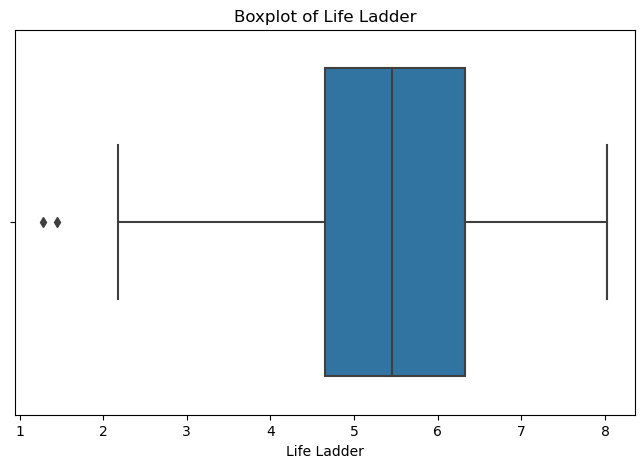

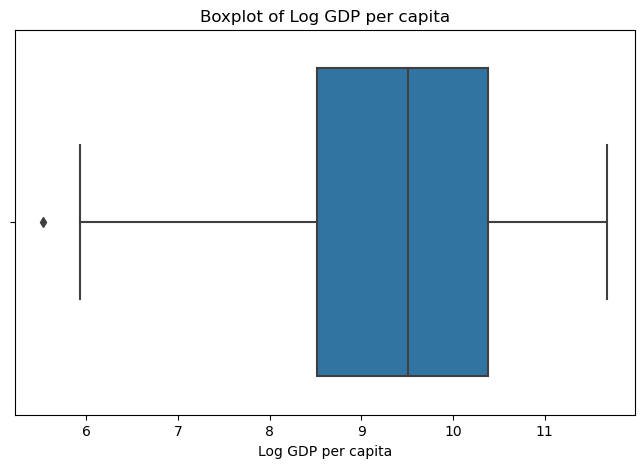

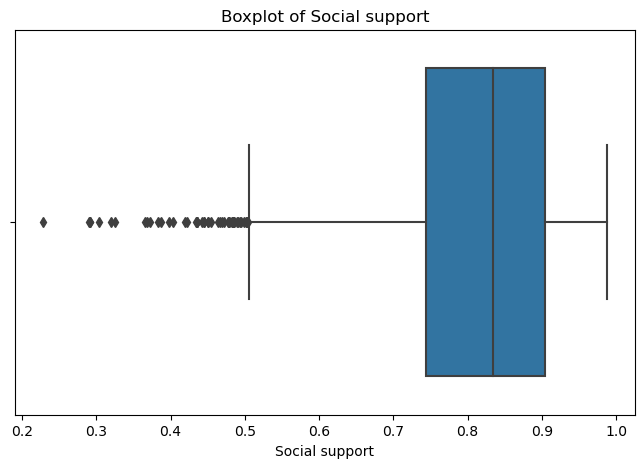

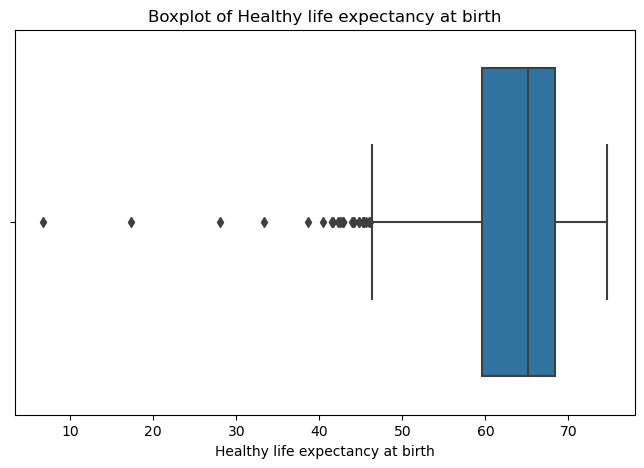

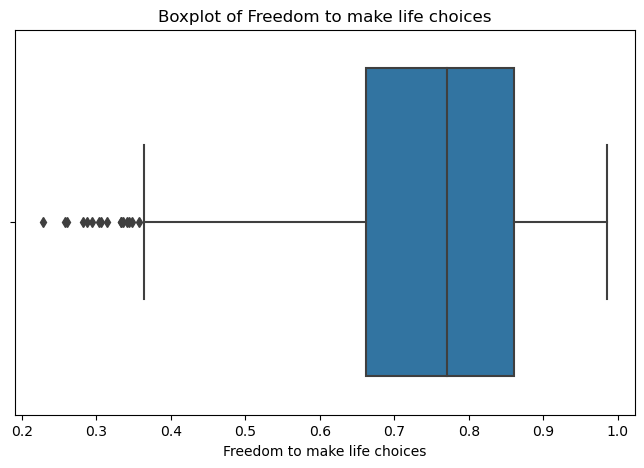

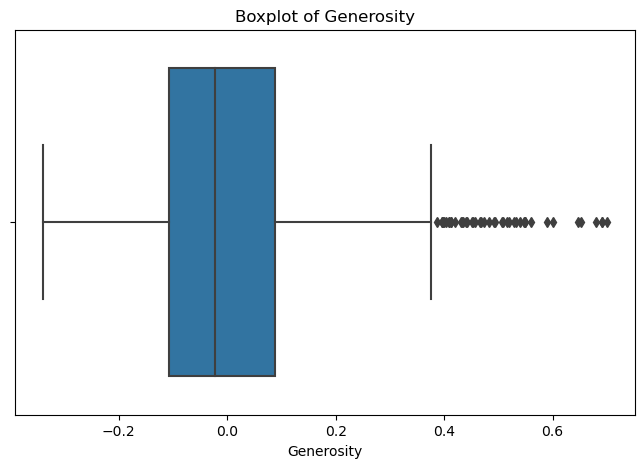

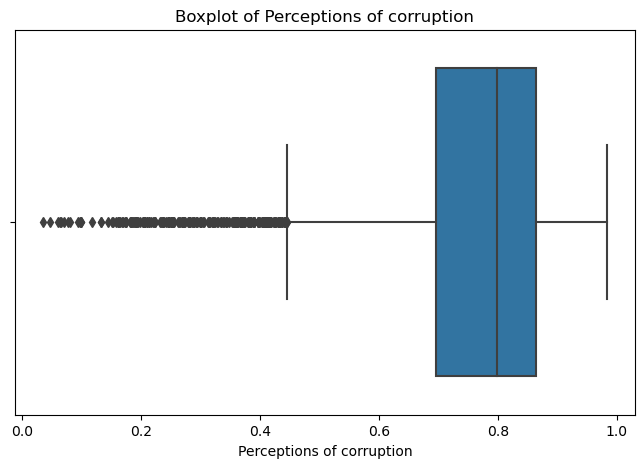

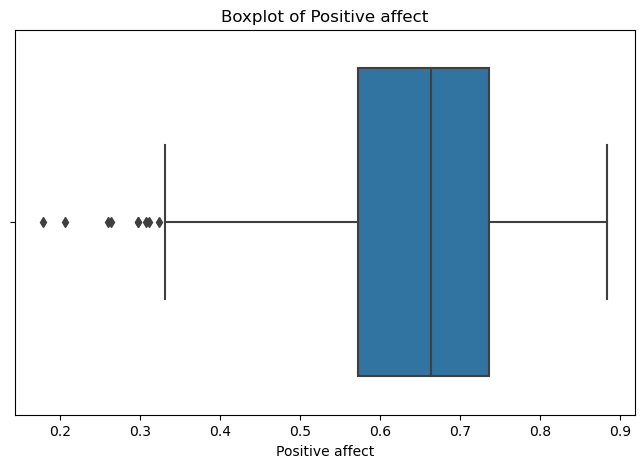

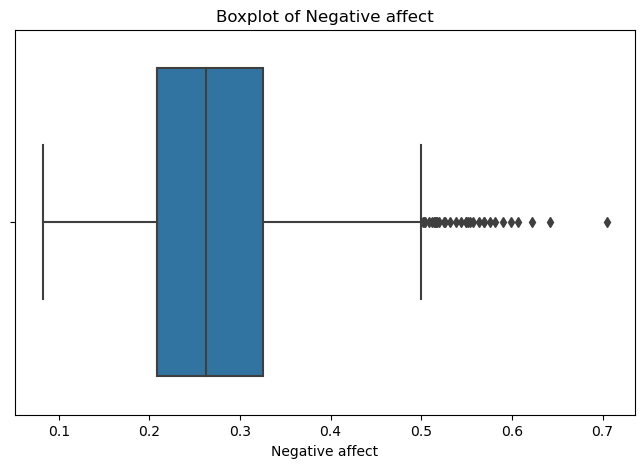

In [13]:
# Boxplots for numerical variables
for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

#### Distribution of Variables

Life ladder
- The boxplot suggests the majority of countries have happiness scores between 5 and 6, with very few outliers below 3.
- This indicates that most countries in the dataset hover around moderate happiness levels. 

Log GDP per capita
- The box plot indicates most countries fall between 9 and 10 on the log scale. There is one significant outlier below 7. 
- The box plot is right-skewed, suggesting economic disparity.

Social support
- The IQR is concentrated between 0.8 and 0.9, with outliers below 0.5. 

Healthy life expectancy at birth
- Most countries fall between 60 and 70 years, with several outliers below 50 and extreme cases below 30.

Freedom to make life choices
- Most values are concentrated between 0.7 and 0.9, with outliers below 0.4.

Generosity
- The IQR centers around 0, with outliers extending up to 0.6 on the positive end. 
- Generosity is less directly tied to happiness but may indicate cultural or religious norms influencing charitable behavior. The outliers suggest unusually high levels of generosity.

Positive Affect
- The IQR ranges between 0.6 and 0.7, with outliers below 0.4. The distribution shows a relatively tight clustering near the upper range.

Negative Affect
- The IQR is concentrated around 0.2–0.3, with outliers extending up to 0.7.

### Distributions of Numberical Variables

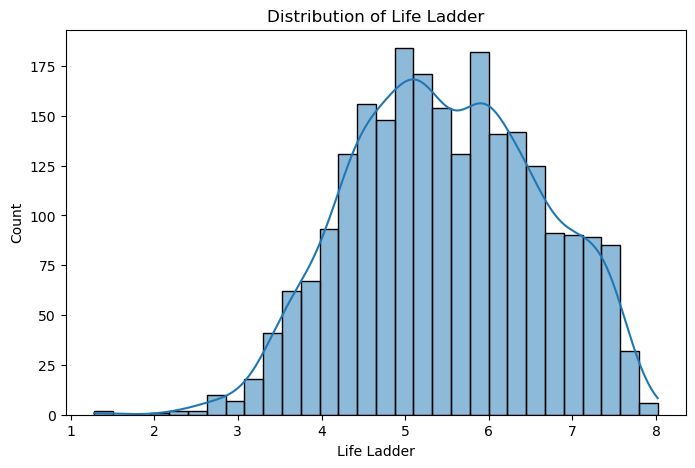

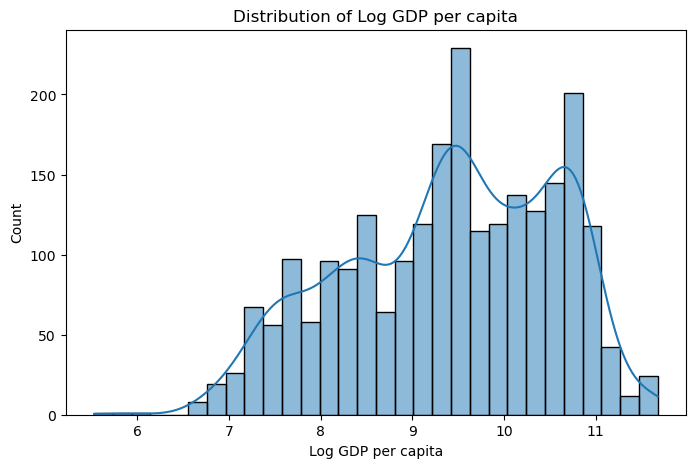

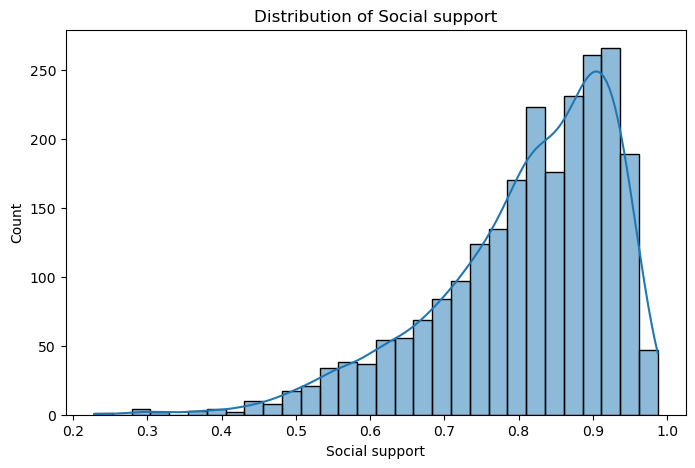

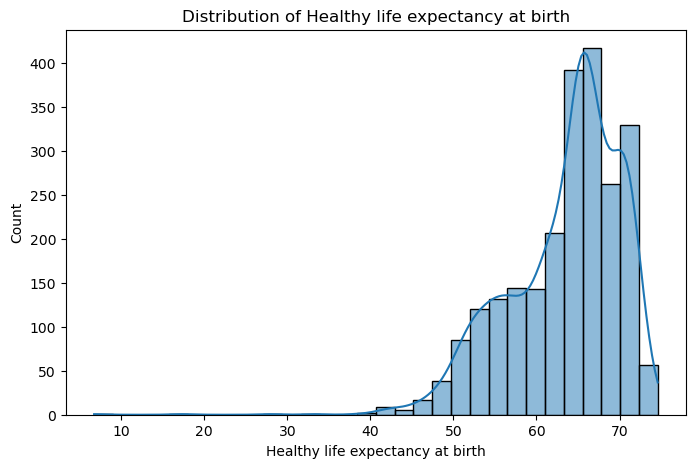

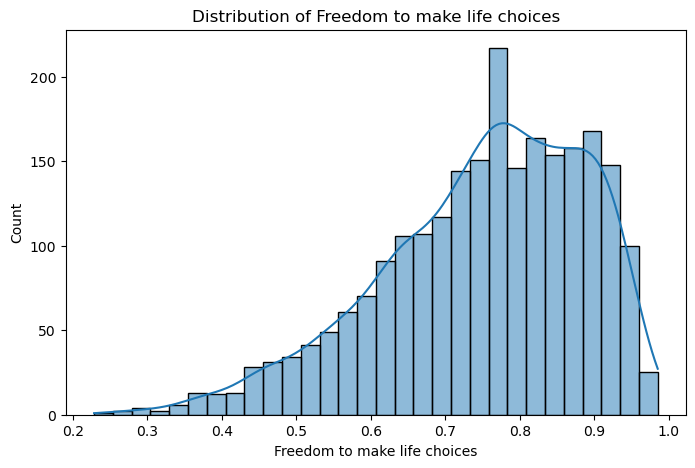

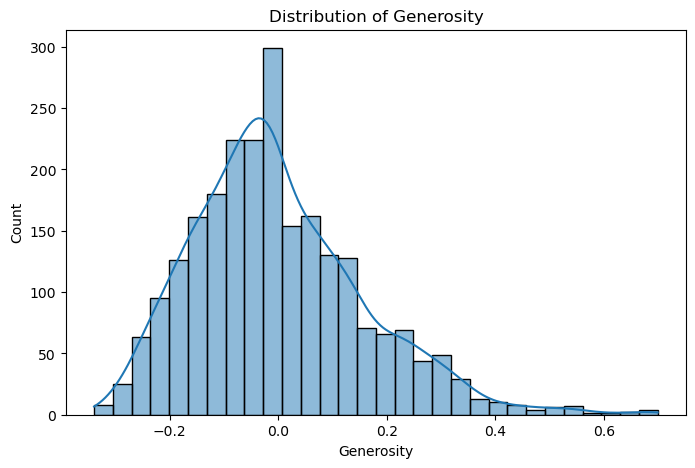

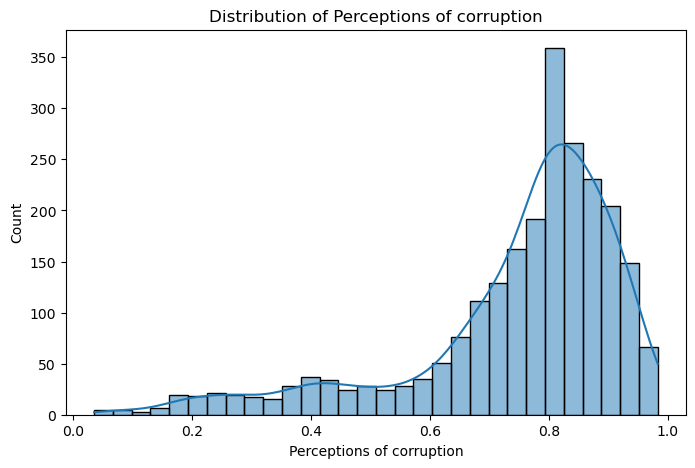

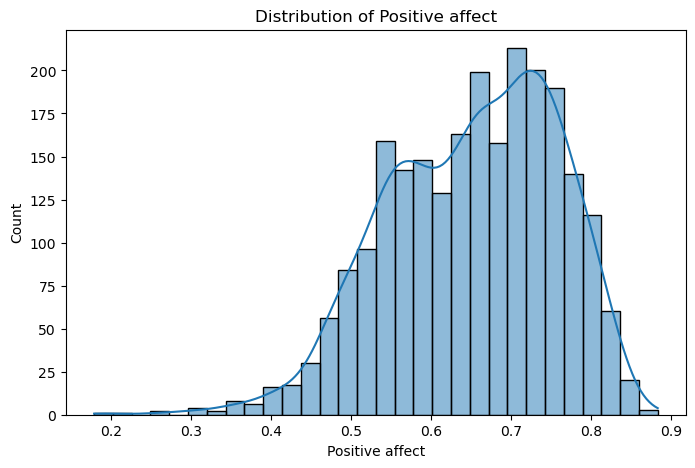

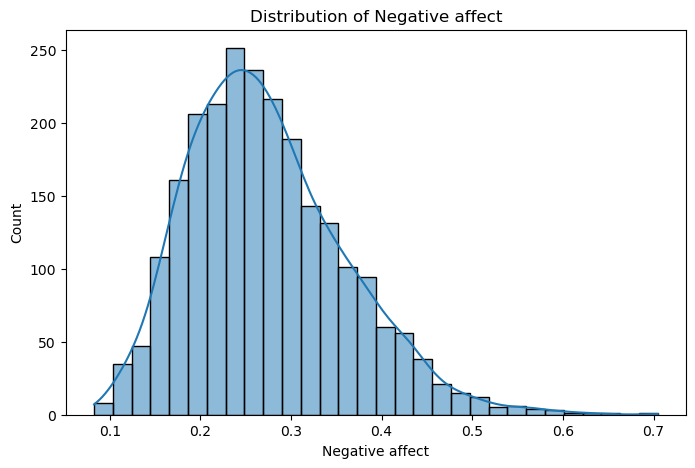

In [14]:
# Select numerical columns excluding "year"
numerical_cols = [col for col in data.select_dtypes(include=['float64', 'int64']).columns if col.lower() != 'year']

# Plot histograms for the remaining numerical columns
for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.show()

#### Distribution of Variables

Life ladder

- The distribution is unimodal and symmetric, with most values concentrated between 5 and 6.
- Outliers below 3 likely represent nations experiencing extreme hardship or conflict, while scores above 7 reflect highly prosperous or socially cohesive nations.

Log GDP per capita

- The distribution is unimodal and slightly right-skewed, with most values concentrated between 9–10.
- Outliers with values below 7 likely represent low-income or developing countries, highlighting economic disparities.

Social support

- The distribution is skewed towards higher values, with most countries scoring between 0.7 and 0.9.
- Outliers below 0.5 could reflect weaker community structures or cultural differences in response patterns.

Life expectancy at birth

- The distribution is slightly skewed, with most values concentrated between 50–70 years.
- Countries with lower life expectancy might be regions facing economic or healthcare challenges.

Freedom to make life choices
- The distribution is slightly skewed towards higher values, with most responses clustering between 0.7 and 0.9.
- Outliers below 0.4 may indicate countries with authoritarian governance or societal restrictions impacting personal freedom.

Generosity
- The distribution is centered around 0, with a slight skew towards positive values and a long tail extending up to 0.6.
- Negative values might result from the residual calculation, while higher positive outliers indicate countries with strong cultural or religious norms promoting charitable behavior. 

Perceptions of corruption
- The distribution is strongly skewed, with most countries scoring between 0.6 and 0.9, indicating high perceptions of corruption globally.
- Outliers below 0.4 suggest countries with strong governance and institutional integrity.

Positive effect
- The distribution is relatively symmetric, with most countries scoring between 0.6 and 0.7.
- Outliers below 0.4 might reflect societal conditions limiting opportunities for positive emotional experiences.

Negative effect
- The distribution is unimodal and skewed towards lower values, with most countries scoring between 0.2 and 0.3.
- Outliers above 0.5 indicate regions with higher levels of worry, sadness, or anger, possibly due to social or economic challenges.

### Categorical Analysis

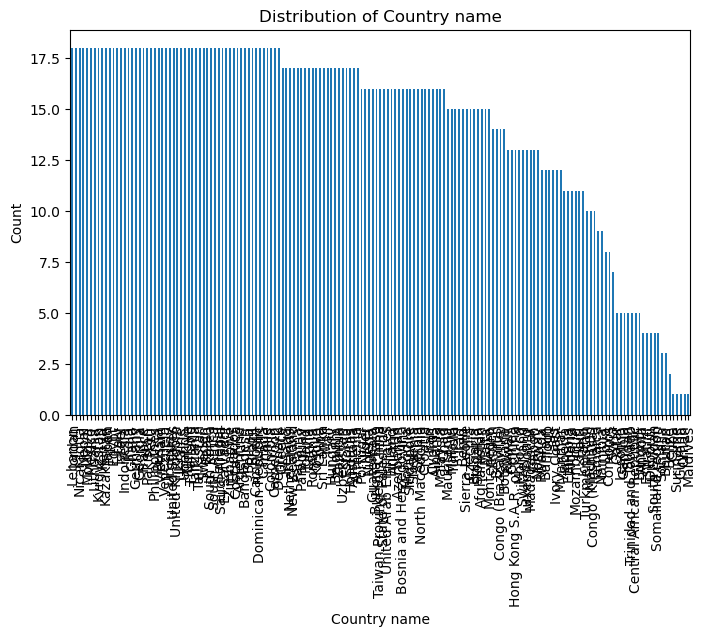

In [15]:
categorical_cols = data.select_dtypes(include=['object']).columns 
for col in categorical_cols:
        plt.figure(figsize=(8, 5))
        data[col].value_counts().plot(kind='bar')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.show()

The bar plot shows the frequency of data points for each country.

Some countries have significantly more entries than others, indicating a potential imbalance in the dataset.

Countries with more data points might disproportionately influence model training, leading to bias.

Countries with fewer data points could represent smaller or less economically significant nations, which might still contribute unique insights.

### Map Representation of Data Points

In [16]:
# Aggregate data by country
country_counts = data['Country name'].value_counts().reset_index()
country_counts.columns = ['Country name', 'Count']

# Plot a choropleth map
fig = px.choropleth(country_counts, locations = "Country name",
                    locationmode = "country names", color="Count",
                    title = "Data Points by Country")
fig.show()

### Correlation Matrix

/var/folders/7z/t8_72tg147b372z_pt1btyvr0000gn/T/ipykernel_5396/2947471287.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



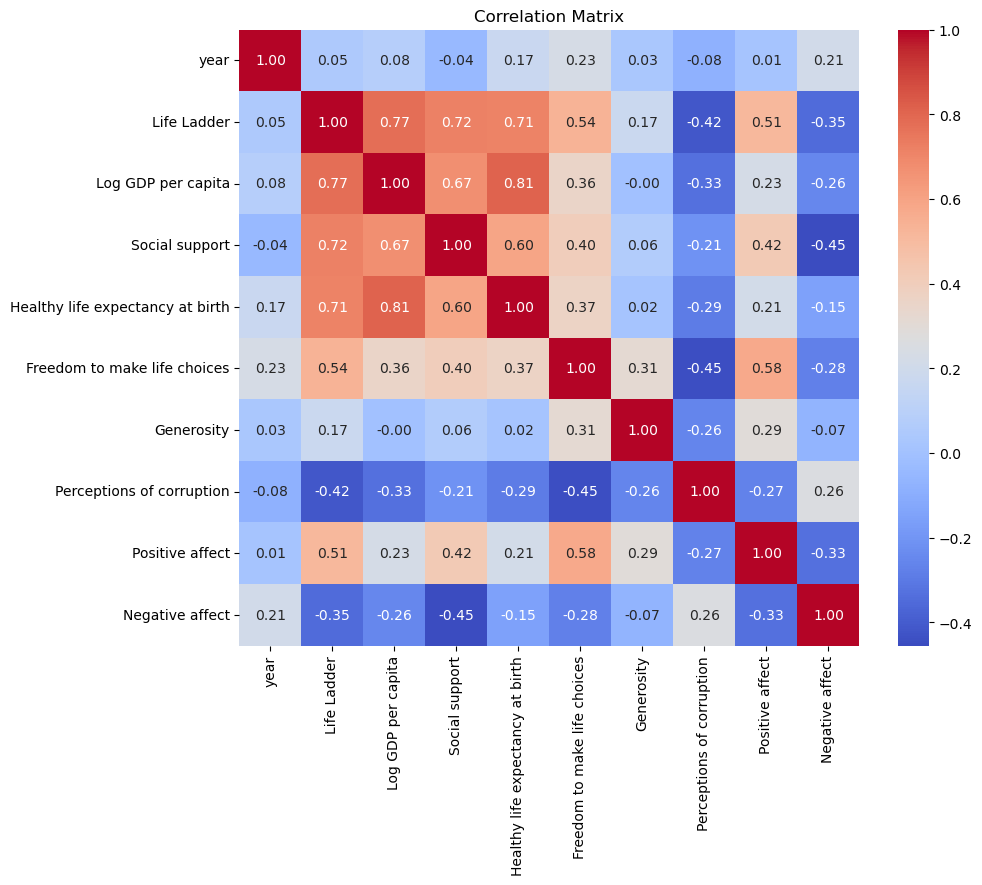

In [17]:
# Correlation matrix
correlation_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

#### Correlation Analysis

- Strong positive correlation between Life Ladder and:
  - Log GDP per Capita (0.77)
  - Social Support (0.72)
  - Healthy Life Expectancy (0.71)
- Strong negative correlation with Perceptions of Corruption (-0.42).
- Freedom to make life choices and Positive Affect show moderate associations.


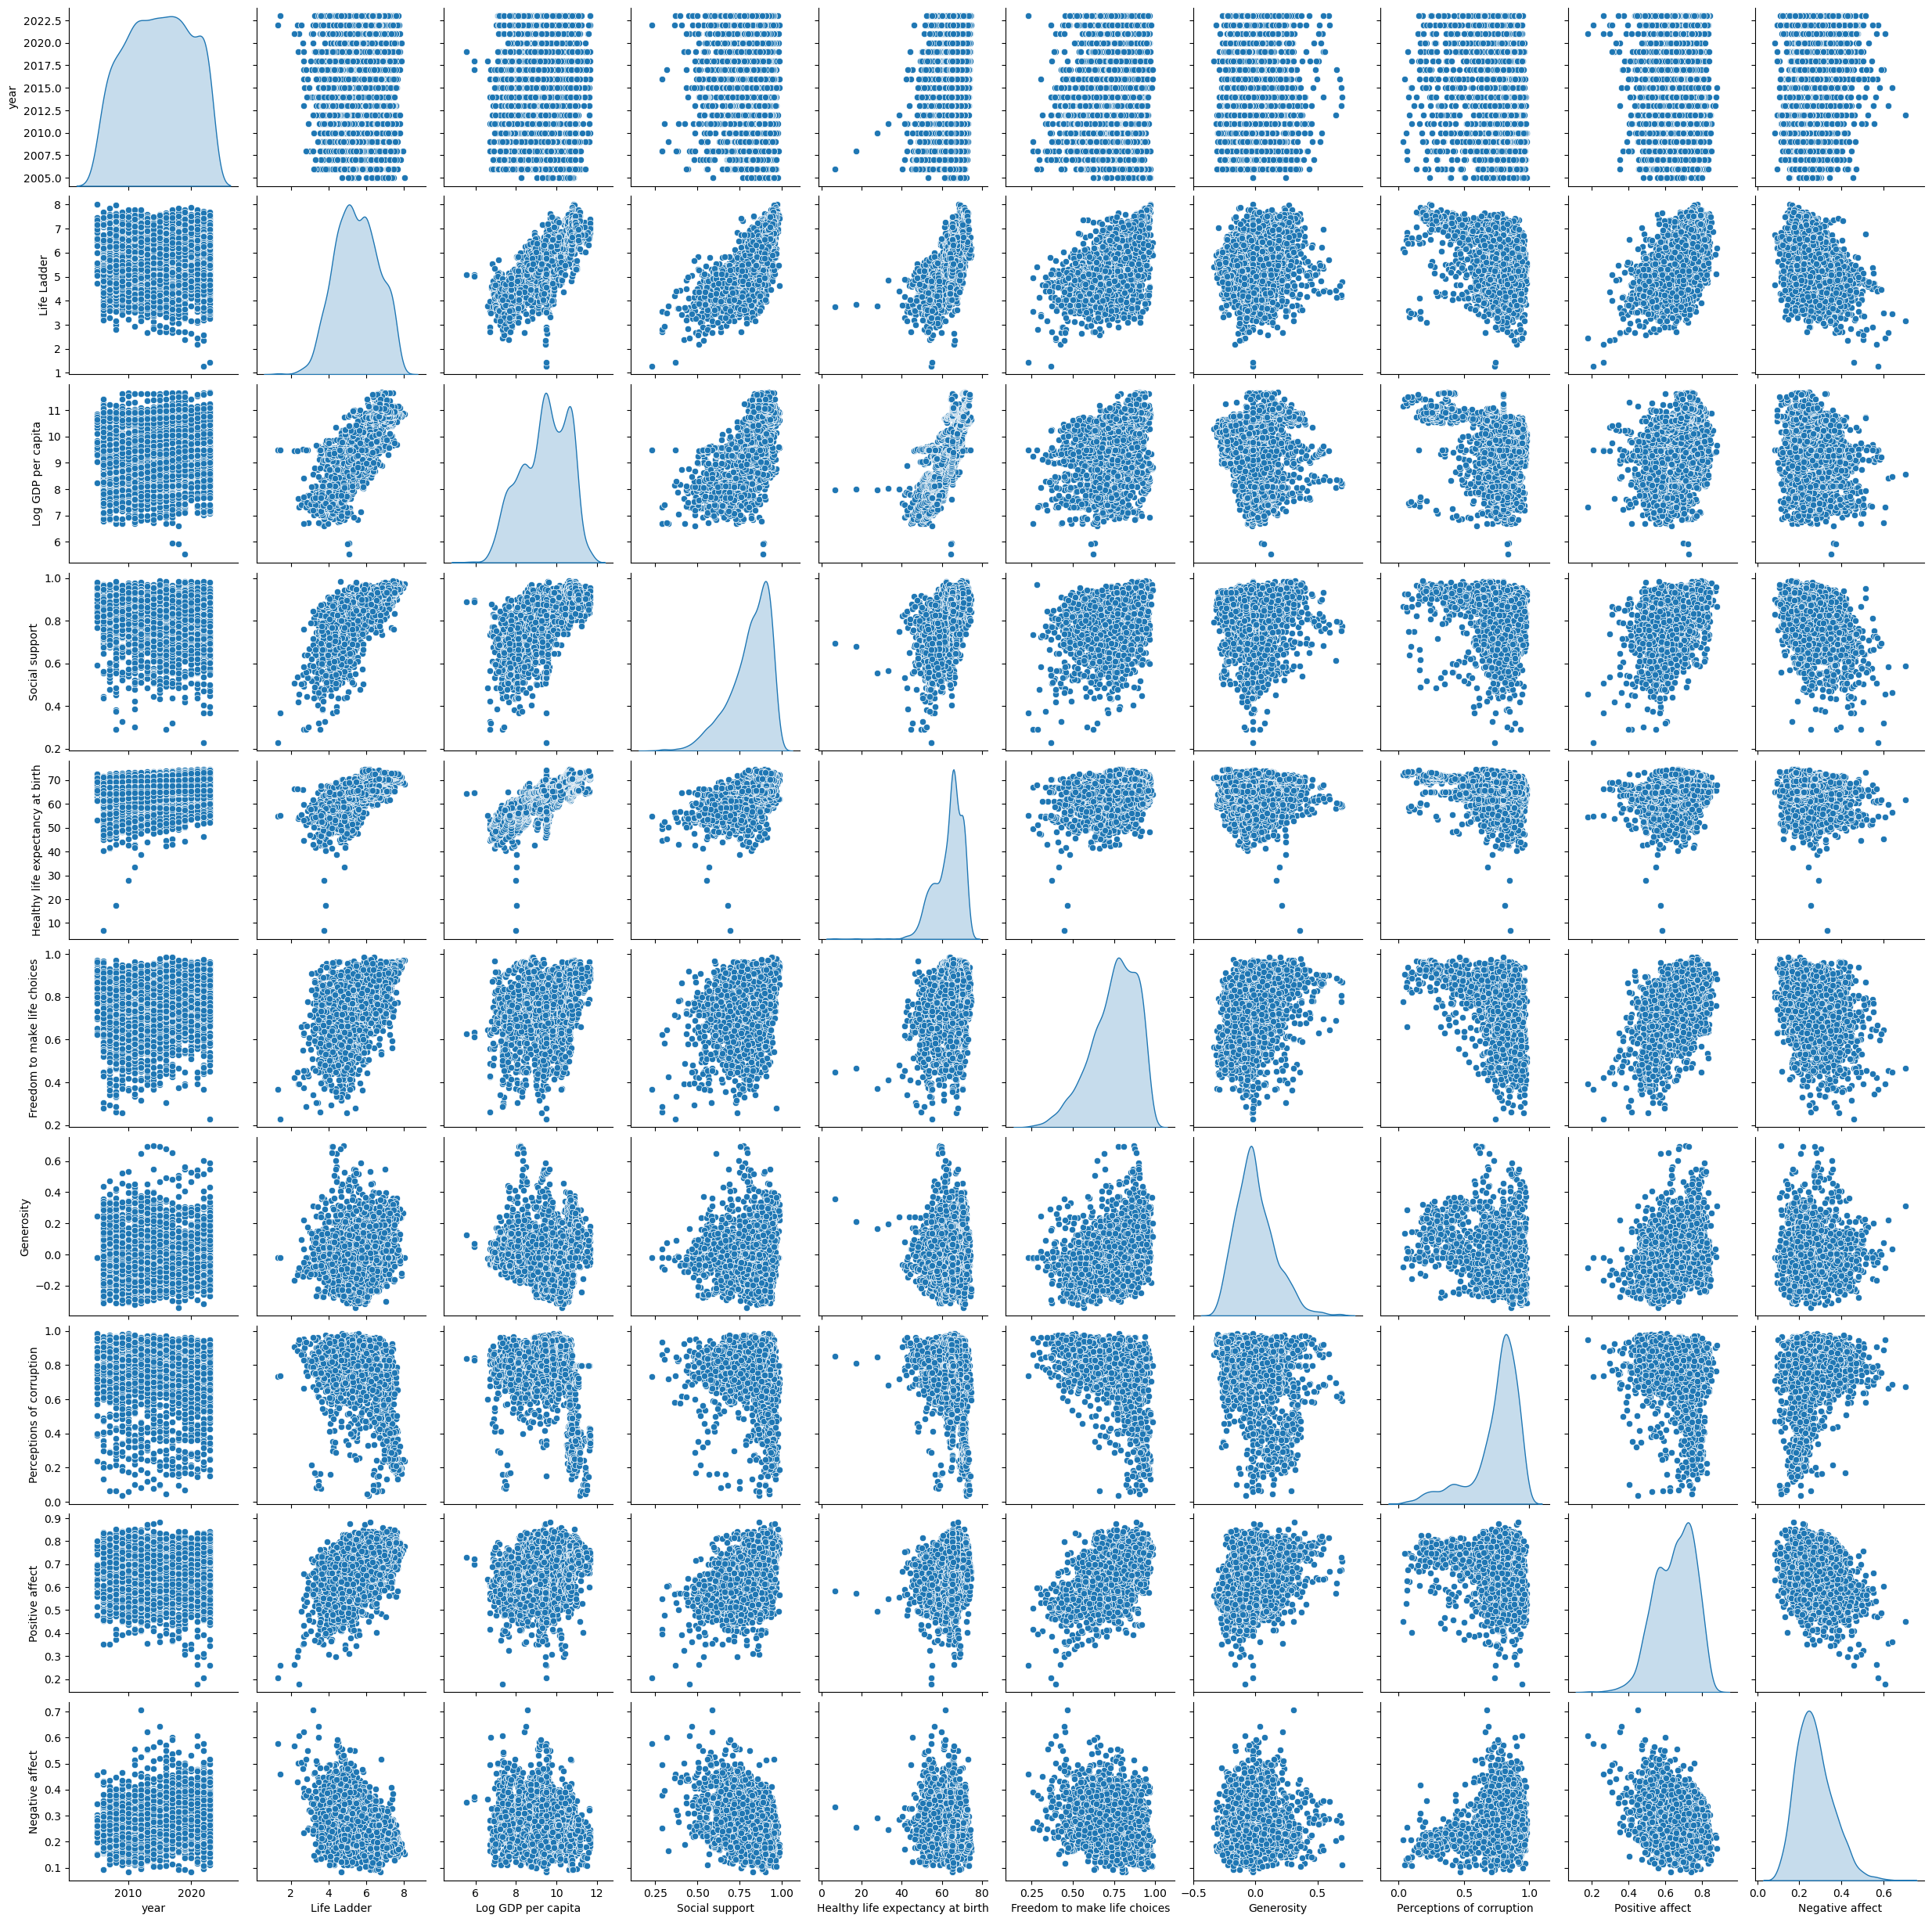

In [18]:
# Pairplot for visualizing relationships between features
sns.pairplot(data, diag_kind='kde')
plt.show()

## Data Preprocessing

In [19]:
# Define features (x) and target variable (y)
feature_cols = [
    'Log GDP per capita',
    'Social support',
    'Healthy life expectancy at birth',
    'Freedom to make life choices',
    'Generosity',
    'Perceptions of corruption',
    'Positive affect',
    'Negative affect'
]

x = data[feature_cols]
y = data['Life Ladder']

Life Ladder represents the happiness score of a country in the dataset. It's a composite measure derived from survey responses and reflects overall well-being, satisfaction, or happiness levels.

Life Ladder is a continuous numerical variable, making it suitable for regression analysis.

In [20]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [21]:
# Scaling numeric features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

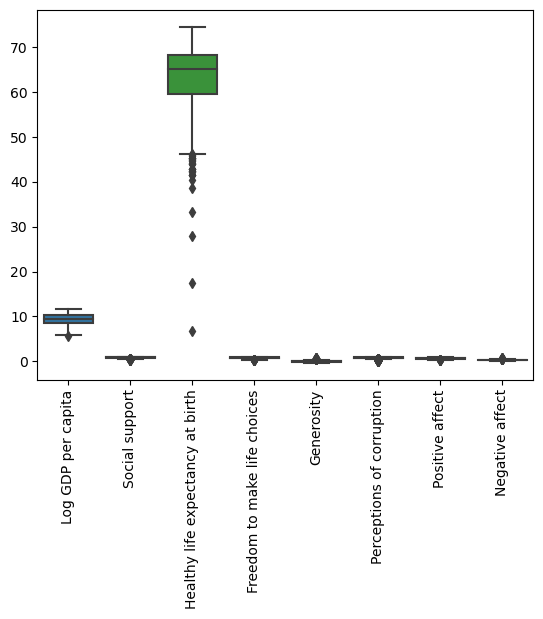

In [22]:
# Identifying outliers
sns.boxplot(data[feature_cols])

plt.xticks(rotation=90)

plt.show()

Log GDP per Capita:

The distribution appears compact, with no significant outliers.
Values are clustered around the median, indicating consistency across observations.

Social Support:

The range of values is small and tightly distributed around the median.
There are no visible outliers, suggesting uniformity in this feature.

Healthy Life Expectancy at Birth:

This feature has a wide range, with many outliers above the upper whisker.
The box is relatively tall, indicating higher variability in this feature across countries.

Freedom to Make Life Choices, Generosity, Perceptions of Corruption, Positive Affect, Negative Affect:

These features have very small ranges and tightly clustered values.
There are no significant outliers visible, except for the slight spread in "Generosity."

In [23]:
# Handle outliers for 'Healthy life expectancy at birth'
feature = 'Healthy life expectancy at birth'
Q1 = data[feature].quantile(0.25)
Q3 = data[feature].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Capping outliers
data[feature] = data[feature].clip(lower=lower_bound, upper=upper_bound)
print(f"Outliers in {feature} handled using IQR-based capping.")

Outliers in Healthy life expectancy at birth handled using IQR-based capping.


In [24]:
# Define features to scale
feature_cols = ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 
                'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 
                'Positive affect', 'Negative affect']

# Min-Max Scaling
scaler = MinMaxScaler()
data_scaled = data.copy()
data_scaled[feature_cols] = scaler.fit_transform(data[feature_cols])

scale all the features using Min-Max Scaling to bring them to a uniform range

In [25]:
# Summary of preprocessing steps
preprocessing_summary = {
    "Training Samples": x_train.shape[0],
    "Test Samples": x_test.shape[0],
    "Scaling Method": "StandardScaler",
    "Features": list(x.columns)
}

preprocessing_summary

{'Training Samples': 1890,
 'Test Samples': 473,
 'Scaling Method': 'StandardScaler',
 'Features': ['Log GDP per capita',
  'Social support',
  'Healthy life expectancy at birth',
  'Freedom to make life choices',
  'Generosity',
  'Perceptions of corruption',
  'Positive affect',
  'Negative affect']}

## 2a: Model Training

### Random Forest Regression

In [26]:
# Initialise and train the Random Forest model
random_forest_model = RandomForestRegressor(random_state = 42)
random_forest_model.fit(x_train_scaled, y_train)

RandomForestRegressor(random_state=42)

### Linear Regression

In [27]:
# Initialize and train the Linear Regression model
linear_regression_model = LinearRegression()
linear_regression_model.fit(x_train_scaled, y_train)

LinearRegression()

### Gradient Boosting Regression

In [28]:
# Initialize and train the Gradient Boosting Regression model
gradient_boosting_model = GradientBoostingRegressor(random_state = 42)
gradient_boosting_model.fit(x_train_scaled, y_train)

GradientBoostingRegressor(random_state=42)

### Support Vector Regression

In [29]:
# Initialize and train the Support Vector Regression model
svr_model = SVR(kernel = 'rbf')
svr_model.fit(x_train_scaled, y_train)

SVR()

### Lasso Regression

In [30]:
# Initialize and train the Lasso Regression model
lasso_model = Lasso(alpha = 0.1)
lasso_model.fit(x_train_scaled, y_train)

Lasso(alpha=0.1)

### Ridge Regression

In [31]:
# Initialize and train the Ridge Regression model
ridge_model = Ridge(alpha = 1.0)
ridge_model.fit(x_train_scaled, y_train)

Ridge()

## 2b: Model Evaluation with Default Parameters

In [32]:
def evaluate_model(model, x_train, x_test, y_train, y_test, model_name):
    
    # Ensure training and testing data are scaled
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test) 
    
    # Fit and predict
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    print(f"{model_name} Performance:")
    print(f"R^2 (Train): {r2_train:.2f}, R^2 (Test): {r2_test:.2f}")
    print(f"RMSE (Train): {rmse_train:.2f}, RMSE (Test): {rmse_test:.2f}\n")

In [33]:
# Evaluate all models
evaluate_model(random_forest_model, x_train_scaled, x_test_scaled, y_train, y_test, "Random Forest")
evaluate_model(linear_regression_model, x_train_scaled, x_test_scaled, y_train, y_test, "Linear Regression")
evaluate_model(gradient_boosting_model, x_train_scaled, x_test_scaled, y_train, y_test, "Gradient Boosting Regression")
evaluate_model(svr_model, x_train_scaled, x_test_scaled, y_train, y_test, "Support Vector Regression")
evaluate_model(lasso_model, x_train_scaled, x_test_scaled, y_train, y_test, "Lasso Regression")
evaluate_model(ridge_model, x_train_scaled, x_test_scaled, y_train, y_test, "Ridge Regression")

Random Forest Performance:
R^2 (Train): 0.98, R^2 (Test): 0.86
RMSE (Train): 0.15, RMSE (Test): 0.42

Linear Regression Performance:
R^2 (Train): 0.77, R^2 (Test): 0.76
RMSE (Train): 0.54, RMSE (Test): 0.55

Gradient Boosting Regression Performance:
R^2 (Train): 0.89, R^2 (Test): 0.83
RMSE (Train): 0.38, RMSE (Test): 0.46

Support Vector Regression Performance:
R^2 (Train): 0.87, R^2 (Test): 0.83
RMSE (Train): 0.41, RMSE (Test): 0.46

Lasso Regression Performance:
R^2 (Train): 0.76, R^2 (Test): 0.73
RMSE (Train): 0.56, RMSE (Test): 0.58

Ridge Regression Performance:
R^2 (Train): 0.77, R^2 (Test): 0.76
RMSE (Train): 0.54, RMSE (Test): 0.55



In [34]:
def evaluate_model(model, x_train, x_test, y_train, y_test, name):
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    print(f"{name} Performance:")
    print(f"R² (Train): {r2_train:.2f}, R² (Test): {r2_test:.2f}")
    print(f"RMSE (Train): {rmse_train:.2f}, RMSE (Test): {rmse_test:.2f}")
    print("-" * 50)
    
    return (r2_test, rmse_test)

In [35]:
# Store results before hyperparameter tuning
results_before = {}

# Evaluate all models
results_before['Random Forest'] = evaluate_model(random_forest_model, x_train_scaled, x_test_scaled, y_train, y_test, "Random Forest (Before)")
results_before['Gradient Boosting'] = evaluate_model(gradient_boosting_model, x_train_scaled, x_test_scaled, y_train, y_test, "Gradient Boosting (Before)")
results_before['SVR'] = evaluate_model(svr_model, x_train_scaled, x_test_scaled, y_train, y_test, "SVR (Before)")
results_before['Lasso'] = evaluate_model(lasso_model, x_train_scaled, x_test_scaled, y_train, y_test, "Lasso (Before)")
results_before['Ridge'] = evaluate_model(ridge_model, x_train_scaled, x_test_scaled, y_train, y_test, "Ridge (Before)")
results_before['Linear Regression'] = evaluate_model(linear_regression_model, x_train_scaled, x_test_scaled, y_train, y_test, "Linear Regression (After)")

Random Forest (Before) Performance:
R² (Train): 0.98, R² (Test): 0.86
RMSE (Train): 0.15, RMSE (Test): 0.42
--------------------------------------------------
Gradient Boosting (Before) Performance:
R² (Train): 0.89, R² (Test): 0.83
RMSE (Train): 0.38, RMSE (Test): 0.46
--------------------------------------------------
SVR (Before) Performance:
R² (Train): 0.87, R² (Test): 0.83
RMSE (Train): 0.41, RMSE (Test): 0.46
--------------------------------------------------
Lasso (Before) Performance:
R² (Train): 0.76, R² (Test): 0.73
RMSE (Train): 0.56, RMSE (Test): 0.58
--------------------------------------------------
Ridge (Before) Performance:
R² (Train): 0.77, R² (Test): 0.76
RMSE (Train): 0.54, RMSE (Test): 0.55
--------------------------------------------------
Linear Regression (After) Performance:
R² (Train): 0.77, R² (Test): 0.76
RMSE (Train): 0.54, RMSE (Test): 0.55
--------------------------------------------------


### Visualising the results

#### Residual Analysis:

Scatter plot of residuals, which is the differences between actual and predicted values, against the predicted values for all models.

Residuals show how far off the model predictions are from the actual values, which is crucial for understanding the model performance and diagnosing issues.

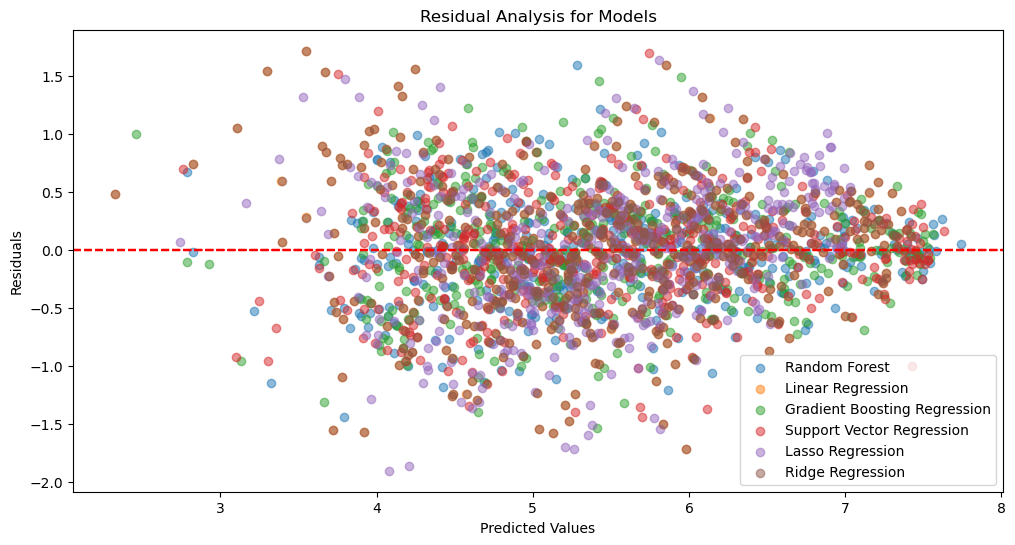

In [36]:
# Residual Analysis

def plot_residuals(model, x_test, y_test, model_name):
    y_test_pred = model.predict(x_test)
    residuals = y_test - y_test_pred

    plt.scatter(y_test_pred, residuals, alpha=0.5, label=model_name)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residual Analysis for Models")

plt.figure(figsize=(12, 6))
plot_residuals(random_forest_model, x_test_scaled, y_test, "Random Forest")
plot_residuals(linear_regression_model, x_test_scaled, y_test, "Linear Regression")
plot_residuals(gradient_boosting_model, x_test_scaled, y_test, "Gradient Boosting Regression")
plot_residuals(svr_model, x_test_scaled, y_test, "Support Vector Regression")
plot_residuals(lasso_model, x_test_scaled, y_test, "Lasso Regression")
plot_residuals(ridge_model, x_test_scaled, y_test, "Ridge Regression")
plt.legend()
plt.show()

## Hyperparameter Tuning

In [37]:
# Random Forest

grid_rf = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]}
gs_rf = GridSearchCV(RandomForestRegressor(random_state=42), grid_rf, cv=5, scoring='neg_mean_squared_error')
gs_rf.fit(x_train_scaled, y_train)
optimized_rf = gs_rf.best_estimator_
print("Optimized Random Forest Parameters:", gs_rf.best_params_)

Optimized Random Forest Parameters: {'max_depth': None, 'n_estimators': 300}


In [38]:
# Gradient Boosting

grid_gb = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
gs_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), grid_gb, cv=5, scoring='neg_mean_squared_error')
gs_gb.fit(x_train_scaled, y_train)
optimized_gb = gs_gb.best_estimator_
print("Optimized Gradient Boosting Parameters:", gs_gb.best_params_)

Optimized Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [39]:
# Support Vector Regression

grid_svr = {'C': [1, 10], 'epsilon': [0.1, 0.2], 'kernel': ['rbf']}
gs_svr = GridSearchCV(SVR(), grid_svr, cv=5, scoring='neg_mean_squared_error')
gs_svr.fit(x_train_scaled, y_train)
optimized_svr = gs_svr.best_estimator_
print("Optimized SVR Parameters:", gs_svr.best_params_)

Optimized SVR Parameters: {'C': 10, 'epsilon': 0.2, 'kernel': 'rbf'}


In [40]:
# Lasso

grid_lasso = {'alpha': [0.01, 0.1, 1.0]}
gs_lasso = GridSearchCV(Lasso(), grid_lasso, cv=5, scoring='neg_mean_squared_error')
gs_lasso.fit(x_train_scaled, y_train)
optimized_lasso = gs_lasso.best_estimator_
print("Optimized Lasso Parameters:", gs_lasso.best_params_)

Optimized Lasso Parameters: {'alpha': 0.01}


In [41]:
# Ridge

grid_ridge = {'alpha': [0.01, 0.1, 1.0]}
gs_ridge = GridSearchCV(Ridge(), grid_ridge, cv=5, scoring='neg_mean_squared_error')
gs_ridge.fit(x_train_scaled, y_train)
optimized_ridge = gs_ridge.best_estimator_
print("Optimized Ridge Parameters:", gs_ridge.best_params_)

Optimized Ridge Parameters: {'alpha': 1.0}


## Model Training Again

In [42]:
optimized_rf.fit(x_train_scaled, y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

In [43]:
optimized_gb.fit(x_train_scaled, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)

In [44]:
optimized_svr.fit(x_train_scaled, y_train)

SVR(C=10, epsilon=0.2)

In [45]:
optimized_lasso.fit(x_train_scaled, y_train)

Lasso(alpha=0.01)

In [46]:
optimized_ridge.fit(x_train_scaled, y_train)

Ridge()

## Model Evaluation Again

In [47]:
def evaluate_model(model, x_train, x_test, y_train, y_test, model_name):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    print(f"{model_name} Performance:")
    print(f"R^2 (Train): {r2_score(y_train, y_train_pred):.2f}, R^2 (Test): {r2_score(y_test, y_test_pred):.2f}")
    print(f"RMSE (Train): {np.sqrt(mean_squared_error(y_train, y_train_pred)):.2f}, RMSE (Test): {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f}\n")
    
    return r2_score(y_test, y_test_pred), np.sqrt(mean_squared_error(y_train, y_train_pred))

In [48]:
# Evaluate all optimised models
evaluate_model(optimized_rf, x_train_scaled, x_test_scaled, y_train, y_test, "Optimized Random Forest")
evaluate_model(optimized_gb, x_train_scaled, x_test_scaled, y_train, y_test, "Optimized Gradient Boosting")
evaluate_model(optimized_svr, x_train_scaled, x_test_scaled, y_train, y_test, "Optimized SVR")
evaluate_model(optimized_lasso, x_train_scaled, x_test_scaled, y_train, y_test, "Optimized Lasso")
evaluate_model(optimized_ridge, x_train_scaled, x_test_scaled, y_train, y_test, "Optimized Ridge")

Optimized Random Forest Performance:
R^2 (Train): 0.98, R^2 (Test): 0.86
RMSE (Train): 0.15, RMSE (Test): 0.42

Optimized Gradient Boosting Performance:
R^2 (Train): 0.98, R^2 (Test): 0.85
RMSE (Train): 0.16, RMSE (Test): 0.44

Optimized SVR Performance:
R^2 (Train): 0.91, R^2 (Test): 0.84
RMSE (Train): 0.34, RMSE (Test): 0.44

Optimized Lasso Performance:
R^2 (Train): 0.77, R^2 (Test): 0.76
RMSE (Train): 0.54, RMSE (Test): 0.55

Optimized Ridge Performance:
R^2 (Train): 0.77, R^2 (Test): 0.76
RMSE (Train): 0.54, RMSE (Test): 0.55



(0.7582116756174534, 0.5350711520147553)

In [49]:
# Store results after hyperparameter tuning
results_after = {}

# Evaluate models with optimized parameters
results_after['Random Forest'] = evaluate_model(optimized_rf, x_train_scaled, x_test_scaled, y_train, y_test, "Random Forest (After)")
results_after['Gradient Boosting'] = evaluate_model(optimized_gb, x_train_scaled, x_test_scaled, y_train, y_test, "Gradient Boosting (After)")
results_after['SVR'] = evaluate_model(optimized_svr, x_train_scaled, x_test_scaled, y_train, y_test, "SVR (After)")
results_after['Lasso'] = evaluate_model(optimized_lasso, x_train_scaled, x_test_scaled, y_train, y_test, "Lasso (After)")
results_after['Ridge'] = evaluate_model(optimized_ridge, x_train_scaled, x_test_scaled, y_train, y_test, "Ridge (After)")
results_after['Linear Regression'] = results_before['Linear Regression']

Random Forest (After) Performance:
R^2 (Train): 0.98, R^2 (Test): 0.86
RMSE (Train): 0.15, RMSE (Test): 0.42

Gradient Boosting (After) Performance:
R^2 (Train): 0.98, R^2 (Test): 0.85
RMSE (Train): 0.16, RMSE (Test): 0.44

SVR (After) Performance:
R^2 (Train): 0.91, R^2 (Test): 0.84
RMSE (Train): 0.34, RMSE (Test): 0.44

Lasso (After) Performance:
R^2 (Train): 0.77, R^2 (Test): 0.76
RMSE (Train): 0.54, RMSE (Test): 0.55

Ridge (After) Performance:
R^2 (Train): 0.77, R^2 (Test): 0.76
RMSE (Train): 0.54, RMSE (Test): 0.55



### Compute MAE for all six models

Mean Absolute Error (MAE) measures the average magnitude of errors between predicted and actual values, this helps us to assess model performance. 

In [50]:
# Define all optimized models
all_models = {
    "Random Forest (Optimized)": optimized_rf,
    "Gradient Boosting (Optimized)": optimized_gb,
    "SVR (Optimized)": optimized_svr,
    "Lasso (Optimized)": optimized_lasso,
    "Ridge (Optimized)": optimized_ridge,
    "Linear Regression": linear_regression_model
}

# Compute MAE for each model
mae_results_all = {}

for model_name, model in all_models.items():
    y_test_pred = model.predict(x_test_scaled)
    mae = mean_absolute_error(y_test, y_test_pred)
    mae_results_all[model_name] = mae

# Convert to DataFrame and sort by MAE
mae_df_all = pd.DataFrame(mae_results_all.items(), columns=["Model", "Mean Absolute Error (MAE)"])
mae_df_all_sorted = mae_df_all.sort_values(by="Mean Absolute Error (MAE)", ascending=True)

# Print results
print("Mean Absolute Error (MAE) for all optimized models:")
print(mae_df_all_sorted.to_string(index=True))

Mean Absolute Error (MAE) for all optimized models:
                           Model  Mean Absolute Error (MAE)
0      Random Forest (Optimized)                   0.310389
2                SVR (Optimized)                   0.329454
1  Gradient Boosting (Optimized)                   0.330485
5              Linear Regression                   0.420959
4              Ridge (Optimized)                   0.420970
3              Lasso (Optimized)                   0.423651


Random Forest is the best model with the lowest MAE of 0.310, suggesting that it makes the smallest average error in predictions.

Linear Regression, Ridge and Lasso models have the highest MAE of 0.42 - 0.43, suggesting that they might struggle more with making accurate predictions.

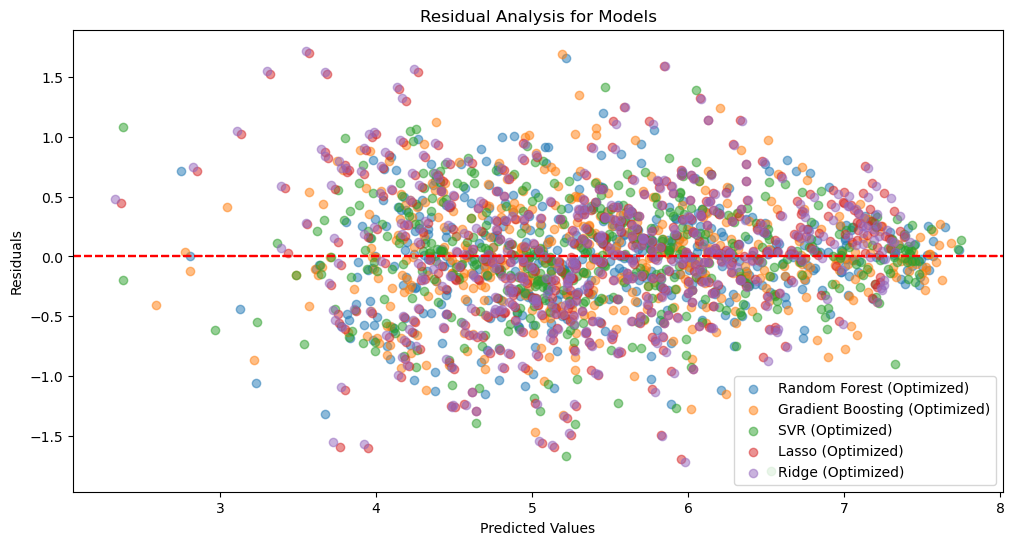

In [51]:
plt.figure(figsize=(12, 6))
plot_residuals(optimized_rf, x_test_scaled, y_test, "Random Forest (Optimized)")
plot_residuals(optimized_gb, x_test_scaled, y_test, "Gradient Boosting (Optimized)")
plot_residuals(optimized_svr, x_test_scaled, y_test, "SVR (Optimized)")
plot_residuals(optimized_lasso, x_test_scaled, y_test, "Lasso (Optimized)")
plot_residuals(optimized_ridge, x_test_scaled, y_test, "Ridge (Optimized)")
plt.legend()
plt.show()

In [52]:
models_before = {
    "Random Forest": random_forest_model,
    "Linear Regression": linear_regression_model,
    "Gradient Boosting": gradient_boosting_model,
    "SVR": svr_model,
    "Lasso": lasso_model,
    "Ridge": ridge_model,
}

In [53]:
models_after = {
    "Random Forest (Optimized)": optimized_rf,
    "Gradient Boosting (Optimized)": optimized_gb,
    "SVR (Optimized)": optimized_svr,
    "Lasso (Optimized)": optimized_lasso,
    "Ridge (Optimized)": optimized_ridge,
}

In [54]:
residuals_before = {}
residuals_after = {}

# Compute residuals before optimization
for model_name, model in models_before.items():
    y_test_pred = model.predict(x_test_scaled)
    residuals_before[model_name] = y_test - y_test_pred

# Compute residuals after optimization
for model_name, model in models_after.items():
    y_test_pred = model.predict(x_test_scaled)
    residuals_after[model_name] = y_test - y_test_pred

### Kernel Density Estimate (KDE) plot 

This is to help us to visualise the distribution of residuals before and after optimisation.

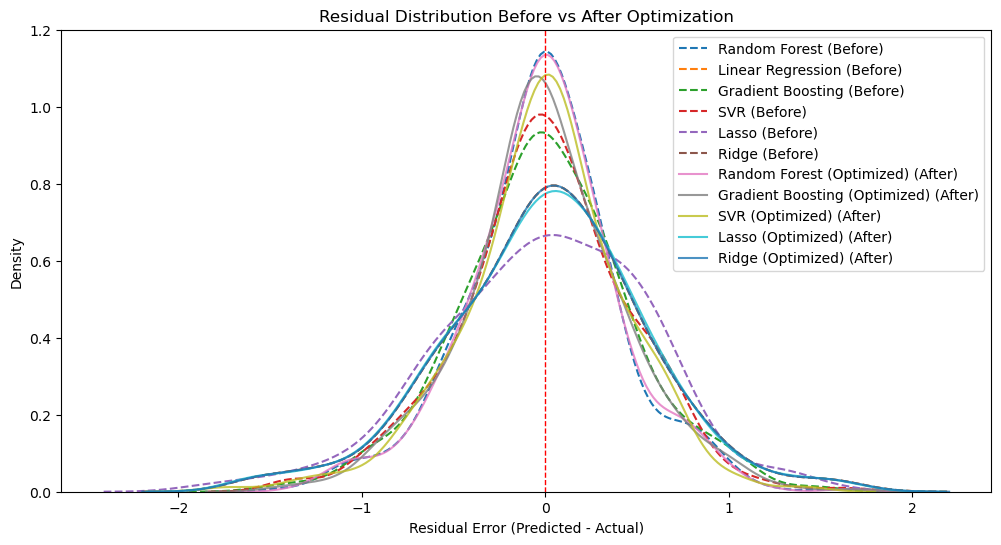

In [55]:
plt.figure(figsize=(12, 6))

# Plot residuals before tuning
for model_name, residuals in residuals_before.items():
    sns.kdeplot(residuals, label=f"{model_name} (Before)", linestyle="--")

# Plot residuals after tuning
for model_name, residuals in residuals_after.items():
    sns.kdeplot(residuals, label=f"{model_name} (After)", alpha=0.8)

plt.axvline(0, color='red', linestyle='--', linewidth=1)  # Zero reference line
plt.title("Residual Distribution Before vs After Optimization")
plt.xlabel("Residual Error (Predicted - Actual)")
plt.ylabel("Density")
plt.legend()
plt.show()

The optimized models have sharper peaks and thinner tails compared to the original models before optimisation. This indicates that after optimisation, most residuals are closer to zero, meaning the models make fewer large prediction errors.

The spread of residuals has also reduced after tuning. This suggests that tuning has helped stabilise predictions, making them less likely to extreme errors.

The red dashed line at zero residual error is the ideal point (perfect prediction). The optimised models have residual distributions that peak closer to zero, confirming improved accuracy.

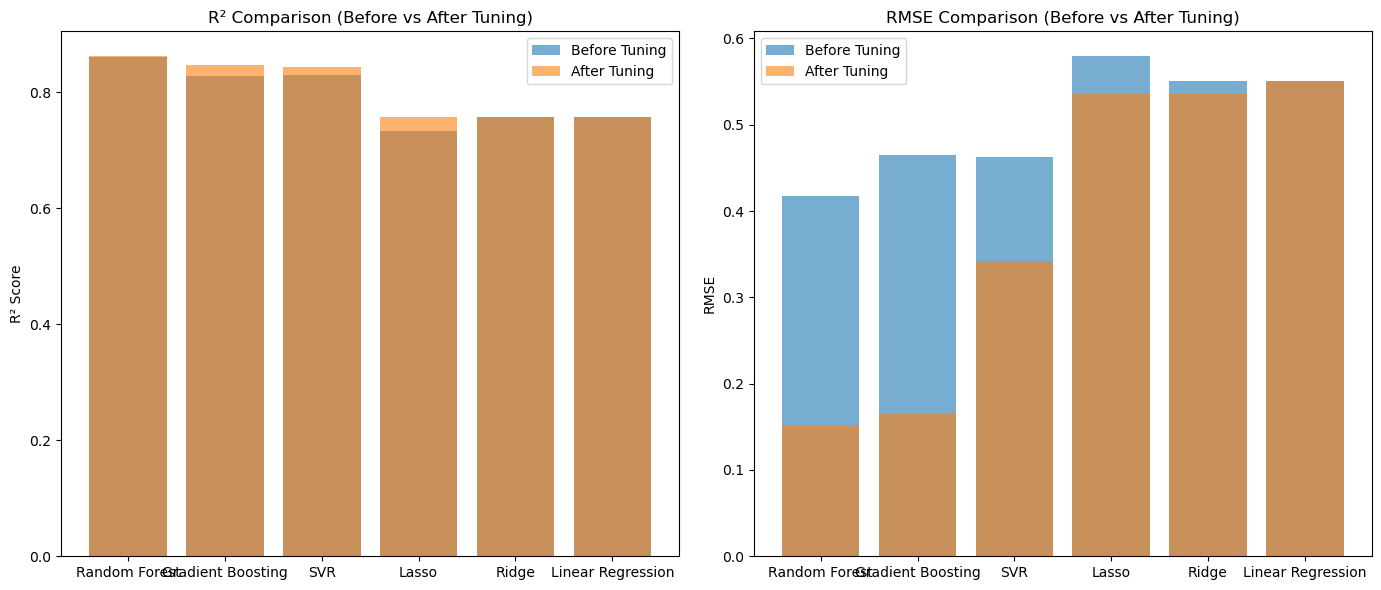

In [56]:
# Visualize the improvement in R^2 and RMSE for each model before and after hyperparameter tuning

# Prepare data for visualization
models = ['Random Forest', 'Gradient Boosting', 'SVR', 'Lasso', 'Ridge', 'Linear Regression']
r2_before = [results_before[model][0] for model in models]
r2_after = [results_after[model][0] for model in models]
rmse_before = [results_before[model][1] for model in models]
rmse_after = [results_after[model][1] for model in models]

# Create subplots for R^2 and RMSE comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot R^2 comparison
ax1.bar(models, r2_before, alpha=0.6, label='Before Tuning')
ax1.bar(models, r2_after, alpha=0.6, label='After Tuning')
ax1.set_title('R² Comparison (Before vs After Tuning)')
ax1.set_ylabel('R² Score')
ax1.legend()

# Plot RMSE comparison
ax2.bar(models, rmse_before, alpha=0.6, label='Before Tuning')
ax2.bar(models, rmse_after, alpha=0.6, label='After Tuning')
ax2.set_title('RMSE Comparison (Before vs After Tuning)')
ax2.set_ylabel('RMSE')
ax2.legend()

plt.tight_layout()
plt.show()

In [57]:
for model in results_after:
    print(model, results_after[model])

Random Forest (0.8621794368576415, 0.15239699869832526)
Gradient Boosting (0.8464665708046897, 0.16472839163688754)
SVR (0.8440678248851323, 0.3425903034174412)
Lasso (0.757346862101828, 0.5353351505372204)
Ridge (0.7582116756174534, 0.5350711520147553)
Linear Regression (0.7582167136034882, 0.5511975073632865)


Random Forest is the best performing model after tuning, achieving the highest accuracy (R²) and lowest prediction error (RMSE). Meanwhile, Lasso, Ridge  and Linear Regression models are the weakest performers, even after optimisation.

## 2c: Feature Importance

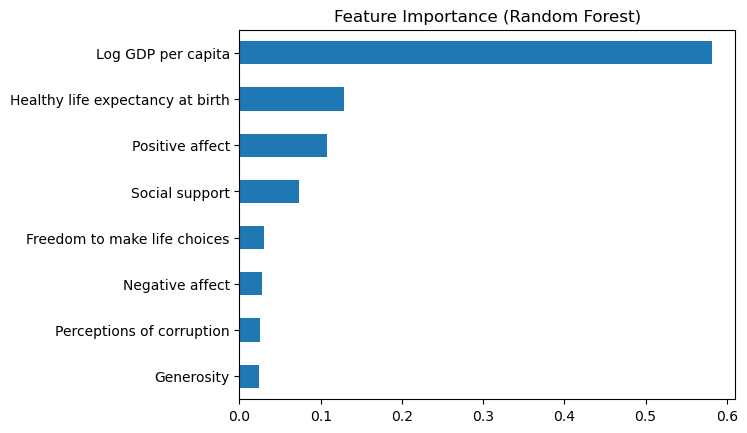

In [58]:
# Feature importance from Random Forest
rf_importances = pd.Series(random_forest_model.feature_importances_, index = feature_cols)
rf_importances.sort_values().plot(kind='barh', title = 'Feature Importance (Random Forest)')
plt.show()

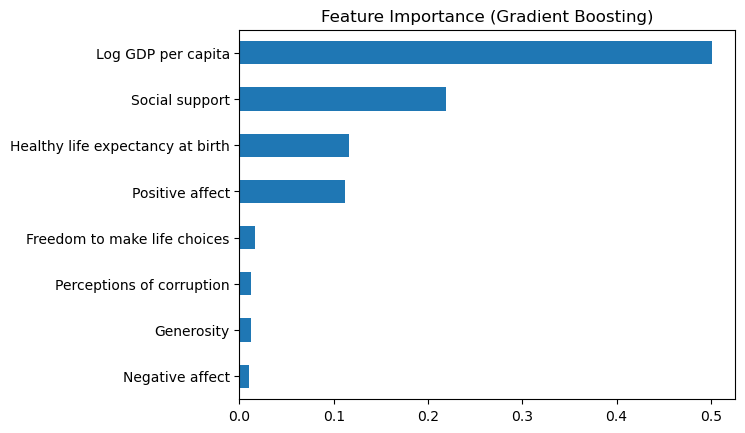

In [59]:
# Feature importance from Gradient Boosting
gb_importances = pd.Series(gradient_boosting_model.feature_importances_, index = feature_cols)
gb_importances.sort_values().plot(kind='barh', title = 'Feature Importance (Gradient Boosting)')
plt.show()

## 2d: Model Comparison

### Residuals VS Fitted

In [60]:
fitted_values_after = {} 

for model_name, model in models_after.items():
    y_test_pred = model.predict(x_test_scaled) 
    fitted_values_after[model_name] = y_test_pred

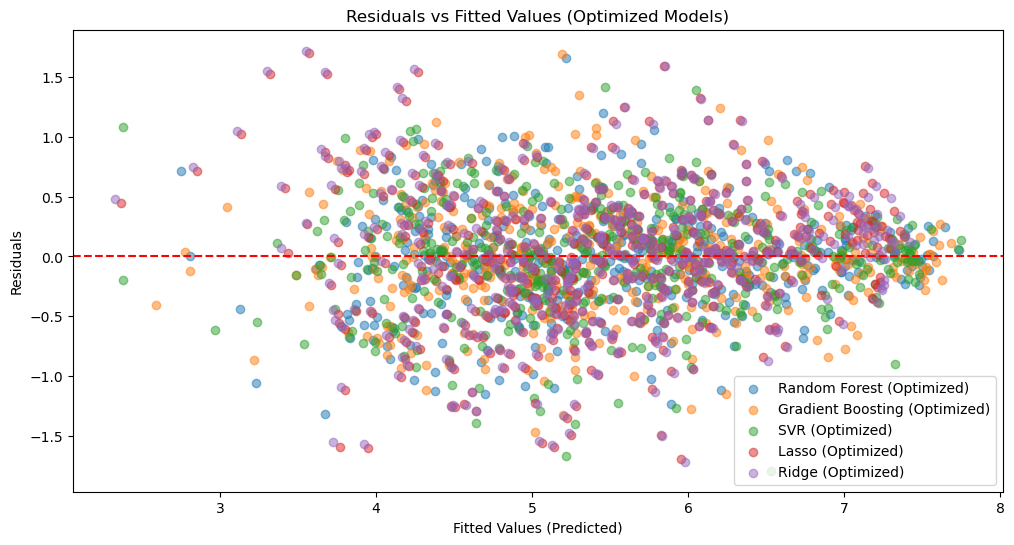

In [61]:
plt.figure(figsize=(12, 6))

for model_name in residuals_after.keys():
    plt.scatter(fitted_values_after[model_name], residuals_after[model_name], alpha=0.5, label=model_name)

plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted Values (Predicted)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values (Optimized Models)")
plt.legend()
plt.show()

x-axis (fitted values): predicted values for each model
y-axis (residuals): difference between actual and predicted values 

residual = actual y - predicted y

The red dashed line at 0 represents the ideal case where residuals are perfectly centered around zero.

The residuals appear to be randomly distributed around zero, which is a good sign. It suggests that the models do not exhibit strong systematic bias.

Gradient Boosting & Random Forest (blue and orange respectively) appear to perform better, as they have less extreme residuals and are more closely clustered around zero.

Lasso & Ridge Regression (purple and pink respectively) show wider spread in residuals, meaning they may not be capturing the full pattern of the data well.

### Actual vs. Predicted Values

Generating the Actual VS Predicted Values scatter plot that compares the actual target values against predicted values for the two best (Random Forest and Gradient Boosting) and the worst (Linear Regression) models. This shows how closely the predictions align with the actual results.

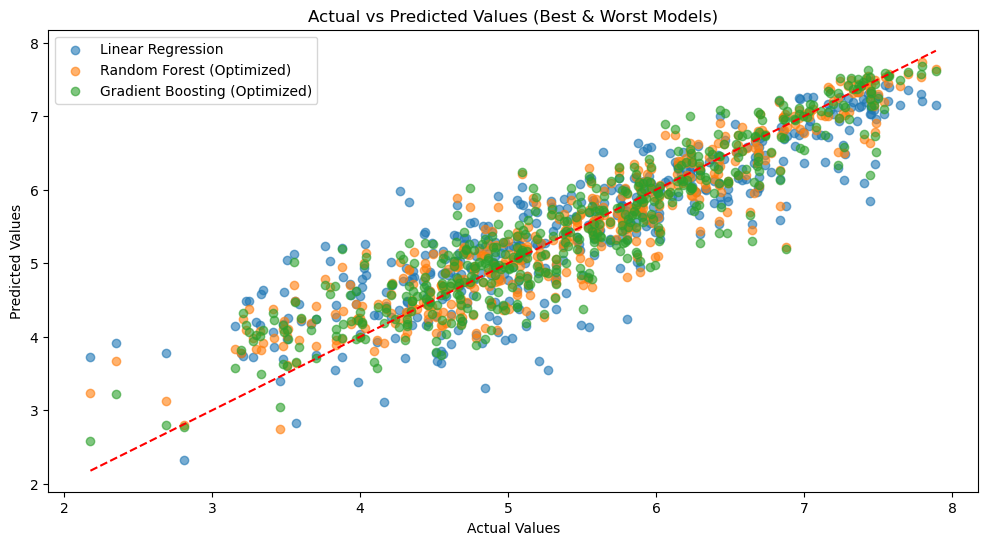

In [62]:
plt.figure(figsize=(12, 6))

# Define selected models for visualization
selected_models = {
    "Linear Regression": linear_regression_model,
    "Random Forest (Optimized)": optimized_rf,
    "Gradient Boosting (Optimized)": optimized_gb,
}

# Scatter plot for selected models
for model_name, model in selected_models.items():
    y_test_pred = model.predict(x_test_scaled)
    plt.scatter(y_test, y_test_pred, alpha=0.6, label=model_name)

# Ideal prediction reference line (y = x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values (Best & Worst Models)")
plt.legend()

# Show plot
plt.show()

Gradient boosting model performs the best as it produces the most accurate predictions with minimal error, with the green points closest to the red ideal predictions line. 

Random forest model also shows good results.

While linear regression model underperforms as many predictions deviate from the ideal predictions line, with many blue points far from the red ideal predictions line which suggests that the model is underfitting. 

### Quantile-Quantile (Q-Q) plot

This is to assess the normality of residuals and determine if the models' errors follow a normal distribution.

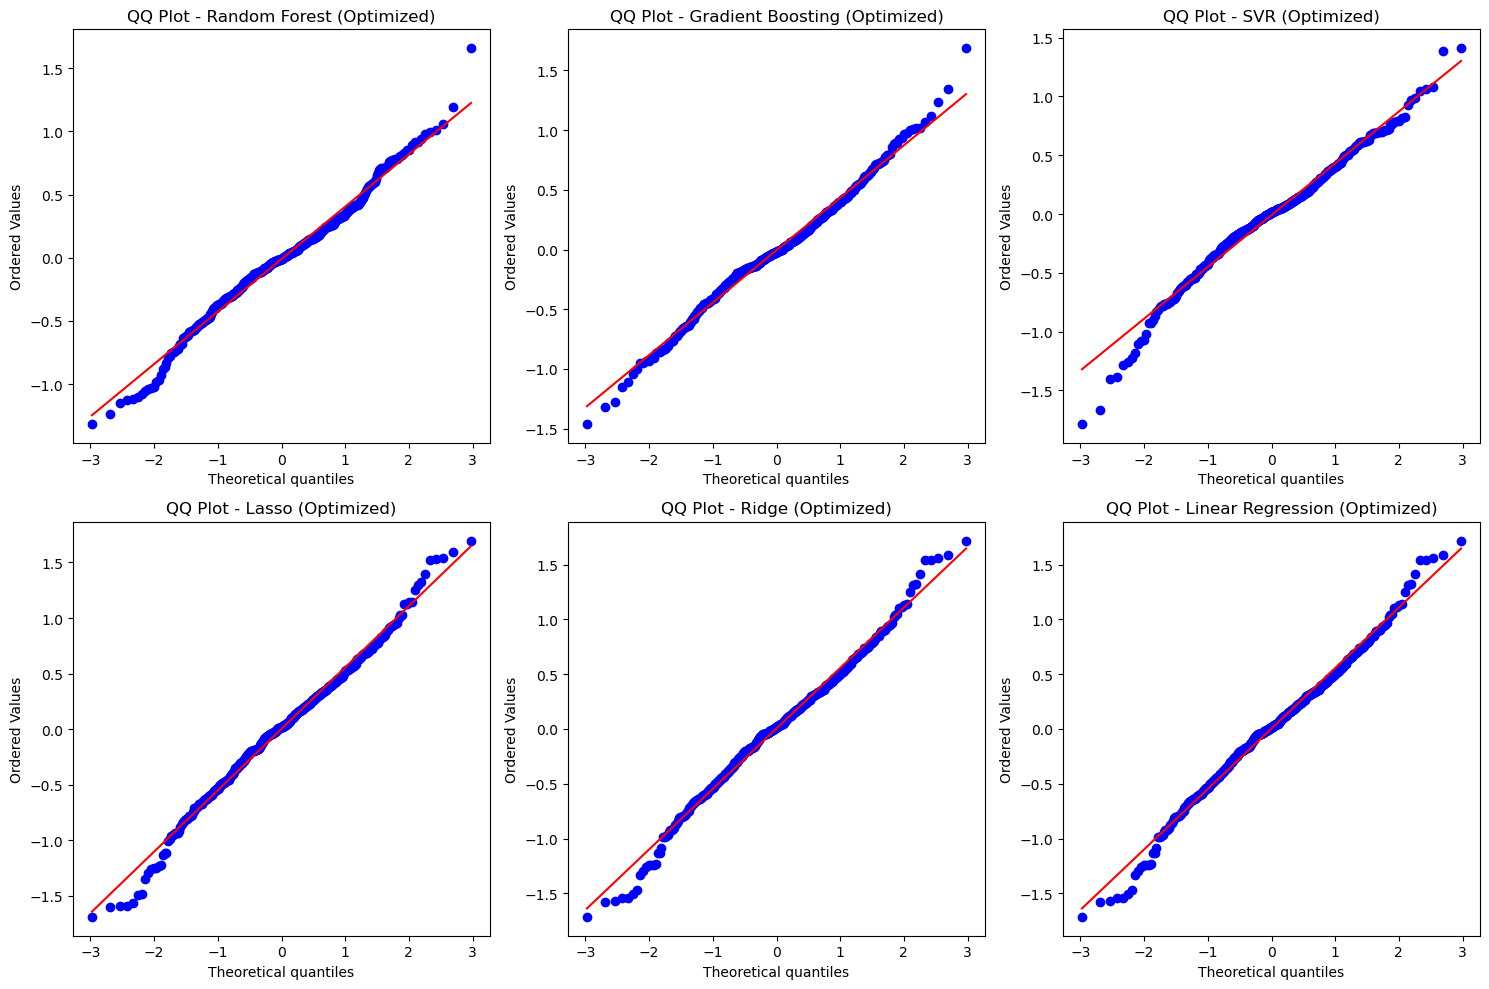

In [67]:
# Compute Residuals for Linear Regression if not already included
if "Linear Regression (Optimized)" not in residuals_after:
    y_test_pred_lr = linear_regression_model.predict(x_test_scaled)
    residuals_after["Linear Regression (Optimized)"] = y_test - y_test_pred_lr

# Generate QQ Plots for all models
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust for 6 models
axes = axes.flatten()

for i, (model_name, residuals) in enumerate(residuals_after.items()):
    stats.probplot(residuals, dist="norm", plot=axes[i])
    axes[i].set_title(f"QQ Plot - {model_name}")

plt.tight_layout()
plt.show()

The QQ (Quantile-Quantile) plots provide insight into the normality of residuals, if the residuals follow a normal distribution, they should align closely with the red reference line.

The best model according to the Q-Q plot is the linear regression model in terms of residual normality, making it a statistically reliable model. While the worst model is the random forest model as it as the worst residual normality which suggests potential overfitting due to its non-linear plot and heavy-tailed errors.

Overall, most models satisfy the normality assumption, but tree-based models (Random Forest and Gradient Boosting) show more deviation.

## Model Performance Metrics Comparison Table

In [64]:
# Table for RMSE and R²
performance_table_rmse_r2 = {
    "Model": [],
    "RMSE": [],
    "R²": []
}

for model_name in results_after.keys():
    r2_value = results_after[model_name][0]  # Extract R²
    rmse_value = results_after[model_name][1]  # Extract RMSE

    performance_table_rmse_r2["Model"].append(model_name)
    performance_table_rmse_r2["RMSE"].append(rmse_value)
    performance_table_rmse_r2["R²"].append(r2_value)

performance_df_rmse_r2 = pd.DataFrame(performance_table_rmse_r2)

print("\nModel Performance - RMSE and R²:")
print(performance_df_rmse_r2.to_string(index=False))


Model Performance - RMSE and R²:
            Model     RMSE       R²
    Random Forest 0.152397 0.862179
Gradient Boosting 0.164728 0.846467
              SVR 0.342590 0.844068
            Lasso 0.535335 0.757347
            Ridge 0.535071 0.758212
Linear Regression 0.551198 0.758217


In [65]:
# Standardize model names
mae_results_all_cleaned = {name.replace(" (Optimized)", ""): value for name, value in mae_results_all.items()}

# Merge RMSE/R² table with MAE table 
final_performance_df = pd.merge(
    performance_df_rmse_r2, 
    pd.DataFrame(list(mae_results_all_cleaned.items()), columns=["Model", "MAE"]), 
    on="Model", 
    how="left"
)

print("\nFinal Model Performance Comparison Table:")
print(final_performance_df.to_string(index=False))


Final Model Performance Comparison Table:
            Model     RMSE       R²      MAE
    Random Forest 0.152397 0.862179 0.310389
Gradient Boosting 0.164728 0.846467 0.330485
              SVR 0.342590 0.844068 0.329454
            Lasso 0.535335 0.757347 0.423651
            Ridge 0.535071 0.758212 0.420970
Linear Regression 0.551198 0.758217 0.420959


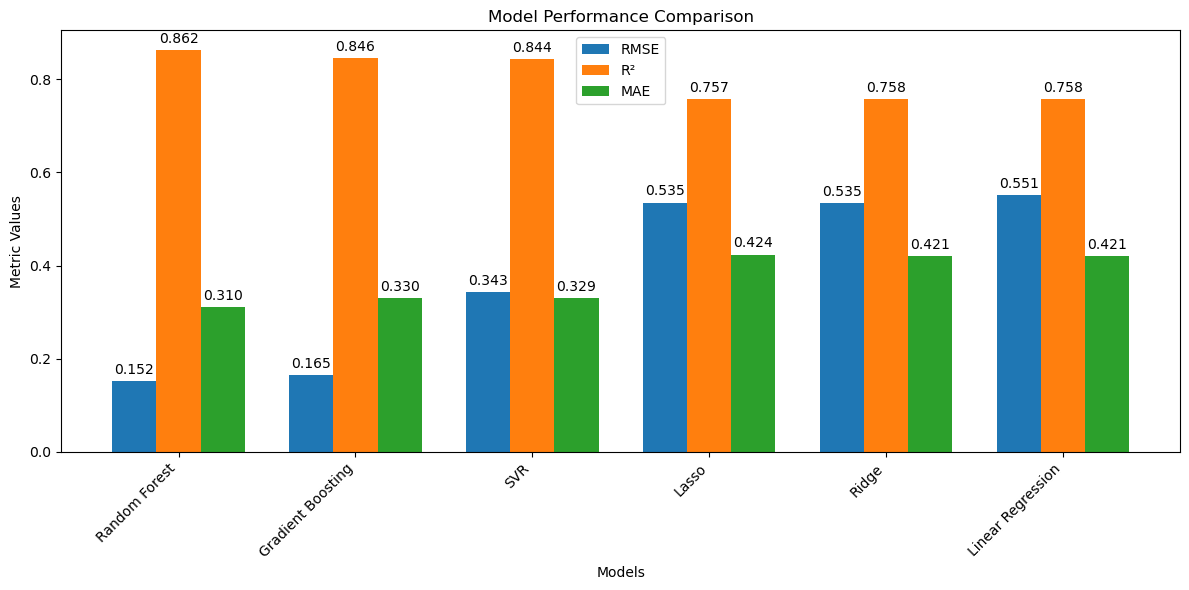

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.25
index = np.arange(len(final_performance_df["Model"]))

bars1 = ax.bar(index, final_performance_df["RMSE"], bar_width, label="RMSE")
bars2 = ax.bar(index + bar_width, final_performance_df["R²"], bar_width, label="R²")
bars3 = ax.bar(index + 2 * bar_width, final_performance_df["MAE"], bar_width, label="MAE")

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

ax.set_xlabel("Models")
ax.set_ylabel("Metric Values")
ax.set_title("Model Performance Comparison")
ax.set_xticks(index + bar_width)
ax.set_xticklabels(final_performance_df["Model"], rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()

Random forest model had the lowest MAE of 0.310 and lowest RMSE of 0.152, this shows that random forest model has the smallest average and squared prediction errors. It also has the highest R² score of 0.862, suggesting that it explained the most variance in the target variable

And the gradient boosting model follows with strong performance across all three metrics: R² of 0.846, MAE of 0.330 and RMSE of 0.165.

While the lasso, ridge and linear regression models all had higher errors (RMSE ≈ 0.535 and MAE ≈ 0.421–0.424) and lower R² values (≈ 0.757–0.758), suggesting they were less effective at capturing the complexity of the data.

SVR had decent performance with R² = 0.844, but slightly higher MAE (0.329) and RMSE (0.343) compared to the tree-based models.

### Model Performance Summary
Random Forest is the best-performing model overall in terms of both accuracy and predictive power.